# Downloads and Libraries


In [1]:
!pip install jams

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.3/51.3 kB 803.6 kB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.7/90.7 kB 9.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for jams: filename=jams-0.3.4-py3-none-any.whl size=64900 sha256=22a62512c3b2509b2e0ce45c480404ab86f1f3cbef0f8b8064f195aac1985f47
  Stored in directory: /root/.cache/pip/wheels/28/9a/f7/fb386b6bc5a75a3ef198a50e98b221e94a381472332b65cf24
  Created wheel for mir_eval: filename=mir_eval-0.7-py3-none-any.whl size=100704 sha256=57637c136f557e74f05868b0dd6334edae69fac6d08ab2bcaa6b89b58373a2b5
  Stored in directory: /root/.cache/pip/wheels/3e/2f/0d/dda9c4c77a170e21356b6afa2f7d9bb078338634ba05d94e3f
Successfully built jams mir_eval


In [2]:
!pip install pydub

In [3]:
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import IPython.display as ipd

In [4]:
FRAME_SIZE = 2048
HOP_LENGTH = 512
sr = 22050

# **Load Data and Create Ground Truth Output**

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [11]:
#path = "/kaggle/input/dsl-project/"
path = '/content/drive/MyDrive/'

In [13]:
import jams

def file_load(file_name):
  file1 = jams.load(file_name)
  return file1.annotations

anot = file_load(path + 'annotation/01_Rock1-90-C#_solo.jams')

In [14]:
#anot

In [15]:
def func(k, arr, anot):

  obj = anot.search(namespace = "note_midi")[k]
  for j in range(len(obj.data)):
    arr.append(obj.data[j][0]) #Get times
    arr.append(obj.data[j][2]) #get midi <(t1, f1)> pairs for all strings.
    arr.append(6 - k) #Append string number as well
  return arr

def get_midi_string_time_info(anot):
  freqs_ = []
  for i in range(6):
    _ = []
    temp = func(i, _, anot)
    freqs_.append(temp)
  return freqs_

freqs_ = get_midi_string_time_info(anot)

In [16]:
import pandas as pd
def df_maker(arr):
  df = {}
  col1 = []
  col2 = []
  col3 = []
  for k in arr:
    for j in range(len(k)):
      if j%3 == 0:
        col1.append(k[j])
      elif j%3 == 1:
        col2.append(k[j])
      else:
        col3.append(k[j])
  df = pd.DataFrame({'Time': col1, 'MIDI': col2, 'String': col3})
  return df.sort_values(by='Time')

df = df_maker(freqs_)

In [17]:
# df = df.sort_values(by='Time')

In [18]:
# print(df.shape)
target_freq = df['String'].to_list()
print(len(target_freq)) # will use this as output

135


In [19]:
!pip install librosa


#Tab Generation: Visual


In [20]:
def create_midi_guitar_map(num_frets=24):
    string_tunings = [40, 45, 50, 55, 59, 64]

    guitar_map = {}

    for string, tuning in enumerate(string_tunings, start=1):
        for fret in range(num_frets + 1):  # +1 because we include the open string
            midi_note = tuning + fret
            guitar_map[(midi_note, 7 - string)] = fret

    return guitar_map
midi_guitar_map = create_midi_guitar_map()

In [21]:

#Ankush
def midi_to_tab_generation(df, num_strings=6, chord_threshold = 0.05):
  tab_lines = [''] * num_strings
  tab_lines[5] = 'E|-'
  tab_lines[4] = 'A|-'
  tab_lines[3] = 'D|-'
  tab_lines[2] = 'G|-'
  tab_lines[1] = 'B|-'
  tab_lines[0] = 'e|-'

  start_time = df['Time'].iloc[0]
  string_used_in_a_frame  = {}
  for note in df.values:
    time, midi, string = note
    if time-start_time > chord_threshold:
      start_time = time
      max_fret_length = 0
      for i in range(num_strings):
        if (i+1) in string_used_in_a_frame:
          fret = string_used_in_a_frame[i+1]
          tab_lines[i] += f"{fret}---"
          max_fret_length = max(len(str(fret)), max_fret_length)
        else:
          tab_lines[i]+='----'
      if max_fret_length > 1:
        for i in range(num_strings):
          if (i+1) not in string_used_in_a_frame or len(str(string_used_in_a_frame[i+1])) < max_fret_length:
            tab_lines[i] += "-"
      string_used_in_a_frame.clear()
    fret = midi_guitar_map[int(round(midi)), int(string)]
    string_used_in_a_frame[string] = fret
    # print(string_used_in_a_frame)

  tab = '\n'.join(tab_lines)
  # print()
  return tab

t = midi_to_tab_generation(df)
print(t)

e|-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------9--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------9-----------
B|---------------------------------------------------------------------------------------------------------------------------------------------6---6---7---7---6-------6--------------------9---------------------------------------------------------9-------------------9-----------9---11---9---7---7---9---7---7---6-------6------------------------------------------------------------------------------------------------------------------------------6---7--------------

In [22]:
df

,Time,MIDI,String
19,0.005235,61.216930,3
20,0.656687,61.016066,3
21,0.769068,63.071903,3
1,1.667140,57.801550,4
22,2.023172,61.014218,3
...,...,...,...
134,31.341358,73.051059,1
131,31.479249,68.072208,2
132,31.662764,68.068125,2
100,31.675553,61.001813,3


# Input Extraction from Music

In [23]:
from pydub.silence import split_on_silence
from pydub import AudioSegment, effects
from scipy.io.wavfile import read, write

def trim_silence_from_audio(path):
  rate, audio = read(path)
  # make the audio in pydub audio segment format
  aud = AudioSegment(audio.tobytes(),frame_rate = rate,
                      sample_width = audio.dtype.itemsize,channels = 1)
  # use split on sience method to split the audio based on the silence,
  # here we can pass the min_silence_len as silent length threshold in ms and intensity thershold
  audio_chunks = split_on_silence(
      aud,
      min_silence_len = 20,
      silence_thresh = -45,
      keep_silence = 20,)
  #audio chunks are combined here
  audio_processed = sum(audio_chunks)
  audio_processed = np.array(audio_processed.get_array_of_samples())

  #Since librosa default sr = 22050, and pydub = 44100, taking half the samples.
  aud_new = []
  for j in range(len(audio_processed)):
    if j%2 == 0:
      aud_new.append(audio_processed[j])
  aud_new = np.array(aud_new)
  audio_processed = aud_new.astype(float)
  return audio_processed

audio_processed = trim_silence_from_audio(path + 'audio_mono-mic/01_Rock1-90-C#_solo_mic.wav')

In [24]:
from IPython.display import Audio
Audio(data=audio_processed, rate=22050)

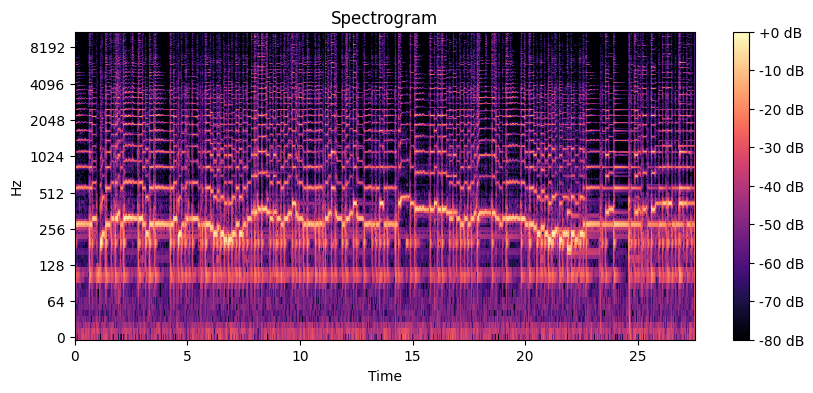

In [25]:

# audio_file = '/content/drive/MyDrive/audio_mono-mic/01_Rock1-90-C#_solo_mic.wav'
def get_spectogram(audio_processed, display="off"):
  # y, sr = librosa.load(audio_file)

  D = librosa.stft(audio_processed, n_fft = FRAME_SIZE)
  spect = librosa.amplitude_to_db(abs(D), ref=np.max)

  if display == "on":
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(spect, sr=sr, x_axis='time', y_axis='log')
    plt.colorbar(format='%+2.0f dB')
    plt.title('Spectrogram')
    plt.show()
  return spect

spect = get_spectogram(audio_processed, "on")

In [26]:
def get_max_freqs(spect):
  freqs = np.arange(0,1+FRAME_SIZE/2)*sr/FRAME_SIZE
  spec_mat = np.array(spect).T
  max_freq_ind = []
  max_intensity = []
  for rows in spec_mat:
    max_freq_ind.append(np.argmax(rows))
    max_intensity.append(np.max(rows))
  max_freq = []
  for ind in max_freq_ind:
    # if freqs[ind] > 1500:
    #   continue
    max_freq.append(freqs[ind])
  return max_freq, max_intensity #np.array(max_freq), np.array(max_intensity)

max_freq, max_intensity = get_max_freqs(spect)

In [27]:
def get_ZCR(audio_processed):
  return librosa.feature.zero_crossing_rate(audio_processed)[0] #np.array(librosa.feature.zero_crossing_rate(audio_processed)[0])

arr = get_ZCR(audio_processed)

# EDA

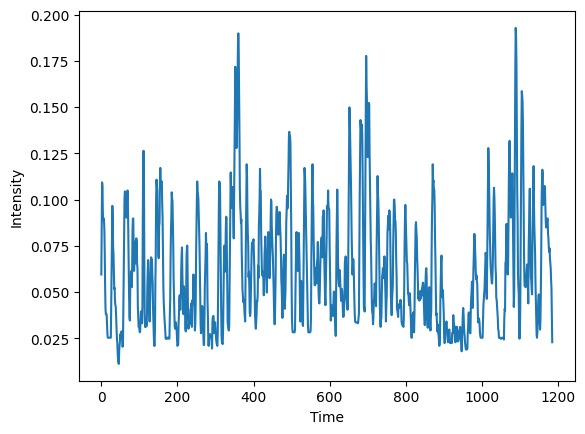

In [28]:
plt.plot(arr)
plt.xlabel('Time')
plt.ylabel('Intensity')
plt.show()

In [29]:
# mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=127)
# plt.figure(figsize = (10, 6))
# librosa.display.specshow(mfccs, x_axis = "time", sr = 22050)
# plt.colorbar(format = "%+2f")
# plt.show()

In [30]:
#mfccs.shape

In [31]:
# del_mfcc = librosa.feature.delta(mfccs)
# plt.figure(figsize = (10, 6))
# librosa.display.specshow(del_mfcc, x_axis = "time", sr = 22050)
# plt.colorbar(format = "%+2f")
# plt.show()

In [32]:
# del2_mfcc = librosa.feature.delta(mfccs, order = 2)
# plt.figure(figsize = (10, 6))
# librosa.display.specshow(del2_mfcc, x_axis = "time", sr = 22050)
# plt.colorbar(format = "%+2f")
# plt.show()

In [33]:
# import statistics
# #pitch detection using YIN algorithm
# pitches = librosa.yin(y, fmin=librosa.note_to_hz('E2'), fmax=librosa.note_to_hz('E7'), frame_length= 2048)
# # Plot pitch contour
# med = statistics.median(pitches)
# '''for j in range(len(pitches)):
#   if pitches[j] > 2*med or pitches[j] < 0.5*med:
#     pitches[j] = med'''
# times = librosa.times_like(pitches)
# plt.figure(figsize=(10, 6))
# plt.plot(times, pitches, label='Pitch (Hz)', color='b')
# plt.xlabel('Time (s)')
# plt.ylabel('Pitch (Hz)')
# plt.title('Pitch Contour')
# plt.legend()
# plt.show()


# Create and feed Model


1.   Load the solo audio
2. Trim the silent spaces
3. For each song, do:
  Extract max freq values, corresponding intensity values and zero-crossing rate
4. for each song,
We’ll get a 3 x (no. of timestamps) array. Now make all the song durations of the same length by zero-padding, of length = max(input)
Similarly, do zero-adding in the output, corresponding to max output size.
Option 2: Repeat that portion of the input which needs to be filled to make all input song lengths of the same size
5. 160 - 20 Train/Test Splits



In [34]:
!ls /content/drive/MyDrive/annotation/ |grep solo|sort

00_BN1-129-Eb_solo.jams
00_BN1-147-Gb_solo.jams
00_BN2-131-B_solo.jams
00_BN2-166-Ab_solo.jams
00_BN3-119-G_solo.jams
00_BN3-154-E_solo.jams
00_Funk1-114-Ab_solo.jams
00_Funk1-97-C_solo.jams
00_Funk2-108-Eb_solo.jams
00_Funk2-119-G_solo.jams
00_Funk3-112-C#_solo.jams
00_Funk3-98-A_solo.jams
00_Jazz1-130-D_solo.jams
00_Jazz1-200-B_solo.jams
00_Jazz2-110-Bb_solo.jams
00_Jazz2-187-F#_solo.jams
00_Jazz3-137-Eb_solo.jams
00_Jazz3-150-C_solo.jams
00_Rock1-130-A_solo.jams
00_Rock1-90-C#_solo.jams
00_Rock2-142-D_solo.jams
00_Rock2-85-F_solo.jams
00_Rock3-117-Bb_solo.jams
00_Rock3-148-C_solo.jams
00_SS1-100-C#_solo.jams
00_SS1-68-E_solo.jams
00_SS2-107-Ab_solo.jams
00_SS2-88-F_solo.jams
00_SS3-84-Bb_solo.jams
00_SS3-98-C_solo.jams
01_BN1-129-Eb_solo.jams
01_BN1-147-Gb_solo.jams
01_BN2-131-B_solo.jams
01_BN2-166-Ab_solo.jams
01_BN3-119-G_solo.jams
01_BN3-154-E_solo.jams
01_Funk1-114-Ab_solo.jams
01_Funk1-97-C_solo.jams
01_Funk2-108-Eb_solo.jams
01_Funk2-119-G_solo.jams
01_Funk3-112-C#_solo.jams


In [35]:
!ls /content/drive/MyDrive/audio_mono-mic/ |grep solo|sort

00_BN1-129-Eb_solo_mic.wav
00_BN1-147-Gb_solo_mic.wav
00_BN2-131-B_solo_mic.wav
00_BN2-166-Ab_solo_mic.wav
00_BN3-119-G_solo_mic.wav
00_BN3-154-E_solo_mic.wav
00_Funk1-114-Ab_solo_mic.wav
00_Funk1-97-C_solo_mic.wav
00_Funk2-108-Eb_solo_mic.wav
00_Funk2-119-G_solo_mic.wav
00_Funk3-112-C#_solo_mic.wav
00_Funk3-98-A_solo_mic.wav
00_Jazz1-130-D_solo_mic.wav
00_Jazz1-200-B_solo_mic.wav
00_Jazz2-110-Bb_solo_mic.wav
00_Jazz2-187-F#_solo_mic.wav
00_Jazz3-137-Eb_solo_mic.wav
00_Jazz3-150-C_solo_mic.wav
00_Rock1-130-A_solo_mic.wav
00_Rock1-90-C#_solo_mic.wav
00_Rock2-142-D_solo_mic.wav
00_Rock2-85-F_solo_mic.wav
00_Rock3-117-Bb_solo_mic.wav
00_Rock3-148-C_solo_mic.wav
00_SS1-100-C#_solo_mic.wav
00_SS1-68-E_solo_mic.wav
00_SS2-107-Ab_solo_mic.wav
00_SS2-88-F_solo_mic.wav
00_SS3-84-Bb_solo_mic.wav
00_SS3-98-C_solo_mic.wav
01_BN1-129-Eb_solo_mic.wav
01_BN1-147-Gb_solo_mic.wav
01_BN2-131-B_solo_mic.wav
01_BN2-166-Ab_solo_mic.wav
01_BN3-119-G_solo_mic.wav
01_BN3-154-E_solo_mic.wav
01_Funk1-114-Ab_sol

In [36]:
annot_files = !ls /content/drive/MyDrive/annotation/ |grep solo|sort
for i in range(len(annot_files)):
  annot_files[i] = f"/content/drive/MyDrive/annotation/{annot_files[i]}"




def create_output(files):
  output_list = []
  for file in files:
    anot = file_load(file)
    freqs_ = get_midi_string_time_info(anot)
    df = df_maker(freqs_)
    freq_list = df['String'].to_list()
    output_list.append(freq_list)

  # Match length to maximum:
  #storing song lengths
  song_lengths = [len(x) for x in output_list]
  # set the max number of 0
  max_len = max([len(x) for x in output_list])
  print(max_len)
  # add zeros to the lists
  temp = [x+ [0]*max_len for x in output_list]
  #Limit the output to the wished length
  output_list = [x[0:max_len] for x in temp]
  idx = 0
  #re-writing the padded zeroes in a song with initial song frequencies
  # for x in output_list:
  #   song_length = song_lengths[idx]
  #   idx+=1
  #   for i in range(song_length,max_len,1):
  #     x[i] = x [i-song_length]

  return output_list

output_list = create_output(annot_files)

243


In [156]:
print(annot_files)

['/content/drive/MyDrive/annotation/00_BN1-129-Eb_solo.jams', '/content/drive/MyDrive/annotation/00_BN1-147-Gb_solo.jams', '/content/drive/MyDrive/annotation/00_BN2-131-B_solo.jams', '/content/drive/MyDrive/annotation/00_BN2-166-Ab_solo.jams', '/content/drive/MyDrive/annotation/00_BN3-119-G_solo.jams', '/content/drive/MyDrive/annotation/00_BN3-154-E_solo.jams', '/content/drive/MyDrive/annotation/00_Funk1-114-Ab_solo.jams', '/content/drive/MyDrive/annotation/00_Funk1-97-C_solo.jams', '/content/drive/MyDrive/annotation/00_Funk2-108-Eb_solo.jams', '/content/drive/MyDrive/annotation/00_Funk2-119-G_solo.jams', '/content/drive/MyDrive/annotation/00_Funk3-112-C#_solo.jams', '/content/drive/MyDrive/annotation/00_Funk3-98-A_solo.jams', '/content/drive/MyDrive/annotation/00_Jazz1-130-D_solo.jams', '/content/drive/MyDrive/annotation/00_Jazz1-200-B_solo.jams', '/content/drive/MyDrive/annotation/00_Jazz2-110-Bb_solo.jams', '/content/drive/MyDrive/annotation/00_Jazz2-187-F#_solo.jams', '/content/dri

In [161]:
annot_files[0][34:]

'00_BN1-129-Eb_solo.jams'

In [56]:
import torch

music_files = !ls /content/drive/MyDrive/audio_mono-mic/ |grep solo|sort
#music_files = !ls /kaggle/input/dsl-project/audio_mono-mic/ |grep solo|sort
for i in range(len(music_files)):
  music_files[i] = f"/content/drive/MyDrive/audio_mono-mic/{music_files[i]}"

def create_input(files):
  input_list = []
  for file in files:
    final_input = []
    audio = trim_silence_from_audio(file)
    spect = get_spectogram(audio)
    max_freq, max_intensity = get_max_freqs(spect)
    zcr = get_ZCR(audio)
    zcr = torch.FloatTensor(zcr)
    max_freq = torch.FloatTensor(max_freq)
    max_intensity = torch.FloatTensor(max_intensity)
    final_input = torch.stack((max_freq,max_intensity,zcr), dim = 0)
    #print(final_input.shape)
    #print(type(final_input))
    input_list.append(final_input)

  song_lengths = [len(x[0]) for x in input_list]
# set the max number of 0
  max_len = max(song_lengths)
#add zeros to the lists
#temp = [torch.zeros(3) for j in range(max_len - song_lengths[k]) for k in range(len(song_lengths))]
#input_list+= torch.stack
  padded_tensor_list = []
  final_input_list = []
  for t in input_list:
        pad_size = max_len - t.shape[1]
        padded_tensor = torch.cat([t, torch.zeros(t.shape[0], pad_size)], dim=1)
        padded_tensor_list.append(padded_tensor)
  stacked_data = torch.stack(padded_tensor_list, dim=0)
  final_input_list.append(stacked_data)

    # input_list.append(np.stack((max_freq, max_intensity, zcr)))

  # Match length to maximum:
  #storing the song lengths
  # song_lengths = [len(x) for x in final_input[0].unsqueeze()]
  # # set the max number of 0
  # max_len = max([len(x) for x in input_list])
  # #add zeros to the lists
  # temp = [torch.zeros(3) for j in range(max_len - song_lengths[k]) for k in range(len(song_lengths))]
  # final_input+=temp
  return final_input_list
  #Limit the output to the desired length
  # input_list = [x[0:max_len] for x in temp]
  # idx = 0
  # #re-writing the padded zeroes in a song with initial song frequencies
  # # for x in input_list:
  # #   song_length = song_lengths[idx]
  # #   idx+=1
  # #   for i in range(song_length,max_len,1):
  # #     x[i] = x [i-song_length]
  # return input_list

input_list = create_input(music_files)


In [57]:
print(len(input_list)) # one song input
print(input_list[0]) #one song's timestamps

1
tensor([[[ 1.5073e+02,  2.0457e+02,  2.0457e+02,  ...,  0.0000e+00,
           0.0000e+00,  0.0000e+00],
         [-1.5099e+01, -7.1156e+00, -3.8588e+00,  ...,  0.0000e+00,
           0.0000e+00,  0.0000e+00],
         [ 4.5898e-02,  6.3477e-02,  7.7637e-02,  ...,  0.0000e+00,
           0.0000e+00,  0.0000e+00]],

        [[ 2.2610e+02,  2.3687e+02,  2.3687e+02,  ...,  0.0000e+00,
           0.0000e+00,  0.0000e+00],
         [-1.2978e+01, -4.3172e+00, -1.4139e+00,  ...,  0.0000e+00,
           0.0000e+00,  0.0000e+00],
         [ 3.8574e-02,  4.7852e-02,  5.7129e-02,  ...,  0.0000e+00,
           0.0000e+00,  0.0000e+00]],

        [[ 7.4290e+02,  7.4290e+02,  2.9608e+03,  ...,  0.0000e+00,
           0.0000e+00,  0.0000e+00],
         [-1.4138e+01, -8.3064e+00, -7.5925e+00,  ...,  0.0000e+00,
           0.0000e+00,  0.0000e+00],
         [ 1.0254e-01,  1.6162e-01,  2.2998e-01,  ...,  0.0000e+00,
           0.0000e+00,  0.0000e+00]],

        ...,

        [[ 3.2300e+02,  3.4453e+0

In [58]:
input_list = input_list[0]

In [59]:
len(input_list[0][0])

1836

In [228]:
import random
def create_dataset(input_list, output_list, k = 150):
  dataset = []
  for i in range(len(input_list)):
    modified_input = []
    for j in range(len(input_list[0][0])):
      modified_input.append(list(input_list[i][:][:,j]))
    dataset.append((input_list[i], output_list[i])) #input_list[i]
    # break
  #return random.sample(dataset, k) #dataset random.sample(dataset, k)
  if k == 150:
    return dataset[:150]
  else:
    return dataset[k:]


In [229]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

# Define a simple dataset class
i=0
class SimpleDataset(Dataset):
    def __init__(self, sample):
        self.data = sample

        self.output_vocab = {char for _, output in self.data for char in output}
        self.output_vocab_size = len(self.output_vocab)
        #self.input_char_to_index = {char: i for i, char in enumerate(sorted(self.input_vocab))}
        self.output_char_to_index = {char: i for i, char in enumerate(sorted(self.output_vocab))}
        print(self.output_vocab)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        # print("Ankush!! Namit!! Nikunj")
        input_seq, output_seq = self.data[index]
        #input_tensor = torch.tensor([self.input_char_to_index[char] for char in input_seq])
        input_tensor = input_seq
        output_tensor = torch.tensor([self.output_char_to_index[char] for char in output_seq])
        return input_tensor, output_tensor

# Define Encoder
class Encoder(nn.Module):
    def __init__(self, hidden_size, num_layers):
        super(Encoder, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        #self.embedding = nn.Embedding(input_size, hidden_size)
        self.rnn = nn.RNN(1836, hidden_size, num_layers, batch_first=True)

    def forward(self, input_seq):
        #embedded = self.embedding(input_seq)
        outputs, hidden = self.rnn(input_seq)
        return outputs, hidden

# Define Decoder
class Decoder(nn.Module):
    def __init__(self, hidden_size, output_size, num_layers):
        super(Decoder, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.embedding = nn.Embedding(output_size, hidden_size)
        self.rnn = nn.RNN(hidden_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)


    def forward(self, input_seq, hidden):
        embedded = self.embedding(input_seq)
        output, hidden = self.rnn(embedded, hidden)
        output = self.fc(output.squeeze(1))
        return output, hidden

# Define Seq2Seq model
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder):
        super(Seq2Seq, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        #self.softmax = nn.LogSoftmax(dim=2)

    def forward(self, source, target, teacher_forcing_ratio=0.5):
        batch_size = source.size(0)
        target_len = target.size(1)
        target_vocab_size = self.decoder.fc.out_features
        outputs = torch.zeros(batch_size, target_len, target_vocab_size).to(source.device)

        encoder_output, hidden = self.encoder(source)

        decoder_input = target[:, 0]

        for t in range(1, target_len):
            output, hidden = self.decoder(decoder_input.unsqueeze(1), hidden)
            outputs[:, t] = output
            teacher_force = torch.rand(1) < teacher_forcing_ratio
            top1 = output.max(1)[1]
            decoder_input = (target[:, t] if teacher_force else top1)

        return outputs


In [230]:
val_set = create_dataset(input_list, output_list, k = 30)
val_dataset = SimpleDataset(val_set)
len(val_dataset)

{0, 1, 2, 3, 4, 5, 6}


150

In [188]:
sample = create_dataset(input_list, output_list)
dataset = SimpleDataset(sample)
len(dataset)

{0, 1, 2, 3, 4, 5, 6}


150

In [189]:
# Set hyperparameters
#input_size = 100 #len(max_freq)
#output_size = 100 #len(target_freq)
hidden_size = 256
num_layers = 1
learning_rate = 1e-5
num_epochs = 20
batch_size = 5

# Initialize dataset and data loader
#sample = create_dataset(input_list, output_list)
#dataset = SimpleDataset(sample)
train_loader = DataLoader(dataset, batch_size=batch_size, shuffle = True)
val_loader = DataLoader(val_dataset, batch_size = 1, shuffle = False)

# Initialize Encoder and Decoder
#encoder = Encoder(dataset.input_vocab_size, hidden_size,num_layers)
encoder = Encoder(hidden_size, num_layers)
decoder = Decoder(hidden_size, dataset.output_vocab_size, num_layers)

# Initialize Seq2Seq model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Seq2Seq(encoder, decoder).to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)


In [190]:
dataset.output_vocab_size

7

In [191]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [192]:
# Training loop
val_loss = []
train_loss = []
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for i, (source, target) in enumerate(train_loader):
        # print(len(source))
        # print(len(target))
        optimizer.zero_grad()
        source, target = source.to(device), target.to(device)
        output = model(source, target)
        output_dim = output.shape[-1]
        output = output[:, 1:].reshape(-1, output_dim)
        target = target[:, 1:].reshape(-1)
#         print("***********************************************************")
#         temp = output.cpu().detach().numpy()
#         show_output = []
#         for i in temp:
#           show_output.append((np.argmax(i)))
#         print((show_output))
        #print(len(temp), len(temp[0]))
        #print((list(target.cpu().detach().numpy())))
        #print(len(list(target.cpu().detach().numpy())))
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    train_loss.append(total_loss / len(train_loader))
    val_loss_ = 0
    model.eval()
    with torch.no_grad():
      for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs_val = model(inputs, labels)
        output_dim = outputs_val.shape[-1]
        outputs_val = outputs_val[:, 1:].reshape(-1, output_dim)
        labels = labels[:, 1:].reshape(-1)
        loss = criterion(outputs_val, labels)
        val_loss_ += loss.item()
    val_loss.append(val_loss_ / len(val_loader))

    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {total_loss / len(train_loader)}, Val_loss: {val_loss_ / len(val_loader)}")


Epoch [1/20], Loss: 1.974411424001058, Val_loss: 1.8612041513125102
Epoch [2/20], Loss: 1.7251453081766763, Val_loss: 1.5991774638493856
Epoch [3/20], Loss: 1.418066716194153, Val_loss: 1.3378743966420492
Epoch [4/20], Loss: 1.1917187968889873, Val_loss: 1.181345707178116
Epoch [5/20], Loss: 1.0549269199371338, Val_loss: 1.0790060222148896
Epoch [6/20], Loss: 0.9727731704711914, Val_loss: 1.0047919650872548
Epoch [7/20], Loss: 0.8794127623240153, Val_loss: 0.9461783150831858
Epoch [8/20], Loss: 0.7995514611403147, Val_loss: 0.8695588012536367
Epoch [9/20], Loss: 0.7361268977324168, Val_loss: 0.8065060714880625
Epoch [10/20], Loss: 0.6920144279797872, Val_loss: 0.7802942484617233
Epoch [11/20], Loss: 0.6692577918370565, Val_loss: 0.7613937278588613
Epoch [12/20], Loss: 0.6424916207790374, Val_loss: 0.7486456125974655
Epoch [13/20], Loss: 0.6277154644330343, Val_loss: 0.7220803717772166
Epoch [14/20], Loss: 0.6128540982802709, Val_loss: 0.7133878221114477
Epoch [15/20], Loss: 0.597011921

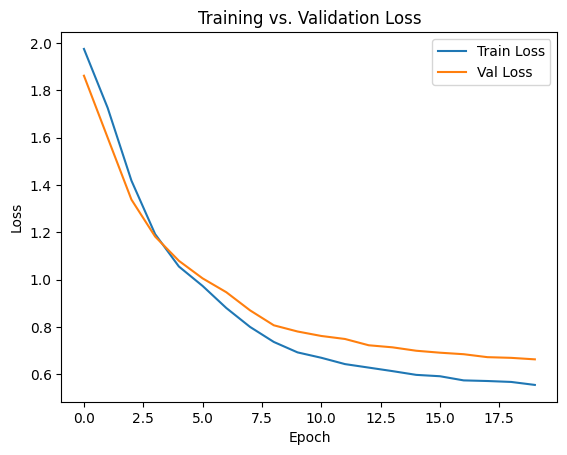

In [193]:
import matplotlib.pyplot as plt

# Plot the training and validation losses
plt.plot(train_loss, label='Train Loss')
plt.plot(val_loss, label='Val Loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs. Validation Loss')
plt.show()

In [68]:
from sklearn.metrics import classification_report

In [194]:
preds = []
for j in outputs_val:
  t = np.array(j.cpu().detach().numpy())
  preds.append(np.argmax(t))

model.eval()

val_preds = []
ground_truth_val = []
with torch.no_grad():
  for inputs, labels in val_loader:
    X_batch = inputs
    X_batch = X_batch.to(device)
    labels = labels.to(device)
    outputs = model(X_batch, labels)
    output_dim = outputs.shape[-1]
    output = outputs[:, 0:].reshape(-1, output_dim)
    target = labels[:, 0:].reshape(-1)
    for preds_ in outputs:
        jtemp = []
        for temp in preds_:
            predicted_class = torch.argmax(outputs, dim=0).cpu().numpy()
            jtemp.append(predicted_class)
        preds.append(jtemp)
    #val_preds.append(preds)
    gb_batch = labels.cpu().detach().numpy()
    for nums in gb_batch:
      #print(nums)
      ground_truth_val.append(nums)
    predicted_class = torch.argmax(output, dim=1).cpu().numpy()
    temp = output.cpu().detach().numpy()
    show_output = []
    for i in temp:
      show_output.append((np.argmax(i)))
    #print(show_output)

    #print("***********************************************************")
    val_preds.append(show_output)



In [195]:
len(val_preds)

30

In [196]:
new_preds = []
for preds in val_preds:
  new_preds.extend(preds)

In [197]:
len(new_preds)

7290

In [198]:
ground_truths_list = []
for arr in ground_truth_val:
  temp = list(arr)
  for nums in temp:
    ground_truths_list.append(nums)

In [199]:
len(ground_truths_list)

7290

In [200]:
cf = classification_report(ground_truths_list, new_preds)

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [201]:
print(cf)

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      4176
           1       0.47      0.31      0.37       549
           2       0.37      0.51      0.43       625
           3       0.44      0.51      0.47       641
           4       0.45      0.54      0.49       591
           5       0.39      0.40      0.40       469
           6       0.00      0.00      0.00       239

    accuracy                           0.75      7290
   macro avg       0.45      0.46      0.45      7290
weighted avg       0.74      0.75      0.74      7290



<Axes: >

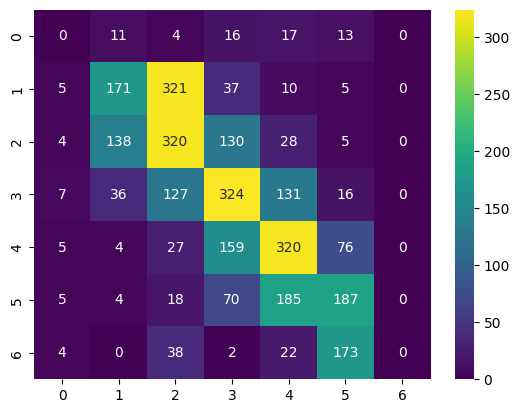

In [202]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

#Get the confusion matrix
cf_matrix = confusion_matrix(ground_truths_list, new_preds)
cf_matrix[0][0] = 0
sns.heatmap(cf_matrix, annot=True, fmt=".0f",cmap='viridis')

In [203]:
val_freqs = []
for inputs, _ in val_loader:
    inputs = inputs.squeeze()
    val_freqs.append(inputs[0].numpy())

In [204]:
#Nikunj
import statistics

def find_runs(lst, threshold):
    groups = []
    curr_group = []
    curr_number = None
    for num in lst:
        num = round(num, 2)
        if curr_number is None:
            curr_group.append(num)
        elif abs(num - curr_number) < threshold:
            curr_group.append(num)
        else:
            try:
                mode = statistics.mode(curr_group)
            except: #fixes the multimodal issue
                mode = round(statistics.mean(curr_group), 2)
            group_count = len(curr_group)
            groups.append([mode, group_count])
            curr_group = [num]
        curr_number = num

    if curr_group:  # Append the last group if it's not empty
        mode = statistics.mode(curr_group)
        group_count = len(curr_group)
        groups.append([mode, group_count])

    final_groups = []
    for temp in groups:
        if temp[1] > 2:
            final_groups.append(temp)

    return final_groups


In [205]:
def fix_groups(groups):
    cor_groups = []
    for group in groups:
        if group[0] > 0:
            cor_groups.append(group)
    return cor_groups

In [206]:
def create_support(groups):
    result = []
    for i, sub_list in enumerate(groups):
        result.append(i)

    result.sort(key=lambda x: -groups[x][1])
    return result

In [207]:
def create_matching_groups(groups, preds, support):

    ans = []
    len_preds = len(preds)
    len_groups = len(groups)
    final_groups = []
    #Here we go
    #Case 1: Split
    if len_preds > len_groups:
        k = len_preds - len_groups
        for j in range(k):
            #print(j)
            #print(groups)
            groups[support[j]][1] = groups[support[j]][1]/2
            temp = [[groups[support[j]][0], groups[support[j]][1]]]
            groups = groups[:support[j]] + temp + groups[support[j]:]
            # for i in range(len(support)):
            #     if support[i] > support[j]:
            #         support[i]+=1
            support = create_support(groups)
        for j in range(len(groups)):
            final_groups.append(groups[j][0])
    #Case 2: remove? --> Ambiguous -> remove last k items
    elif len_preds < len_groups:
        k = len_groups - len_preds
        for j in support[-k:]:
            groups[j][0] = -1
        for j in range(len(groups)):
            if groups[j][0]!= -1:
                final_groups.append(groups[j][0])

    for j in range(len(final_groups)):
        ans.append([final_groups[j], preds[j]])

    return ans

In [208]:
def rem_zeros_from_preds(song_preds):
    fin = []
    for j in song_preds:
        if j>0:
            fin.append(j)
    return fin

In [209]:
string_frequency_pair = []

for j in range(len(val_preds)):
    strings_pred = val_preds[j]
    song_freqs = val_freqs[j]
    run = find_runs(song_freqs, 18)
    #Preprocessing strings & groups
    strings_pred = rem_zeros_from_preds(strings_pred)
    run = fix_groups(run)
    support = create_support(run)
    #final groups
    groups_after_processing = create_matching_groups(run, strings_pred, support)
    string_frequency_pair.append(groups_after_processing)

In [210]:
def check_if_possible(freq_string_pair):

    lowest = [82, 110, 147, 196, 247, 330]
    highest = [lowest[j]*4 for j in range(6)]
    freq = freq_string_pair[0]
    string = freq_string_pair[1]
    ans = [freq, string]

    if freq > lowest[6 - string] and freq < highest[6 - string]:
        return ans
    if freq < lowest[6 - string]:
        base_string = string
        while (freq < lowest[6 - string]):
            if 5 - string < 0:
                while freq < lowest[6 - base_string]:
                    freq = 2*freq
                return [freq, base_string]
            else:
                string+=1
    if freq > highest[6 - string]:
        base_string = string
        while (freq > highest[6 - string]):
            if string == 1:
                while freq > highest[6 - base_string]:
                    freq = freq/2
                return [freq, base_string]
            else:
                string-=1
    return [freq, string]


In [211]:
corrected_sf_pairs = []
for song in string_frequency_pair:
    sf_per_song = []
    for temp in song:
        temp_ = check_if_possible(temp)
        sf_per_song.append(temp_)
    corrected_sf_pairs.append(sf_per_song)

In [212]:
import math

def freq_to_midi(freq):
    return 69 + 12*math.log2(freq/440) #nice


In [213]:
corrected_mid_string_pairs = []
for sf_pair in corrected_sf_pairs:
    midi_string = []
    for j in range(len(sf_pair)):
        temp = sf_pair[j]
        midi_value = freq_to_midi(temp[0])
        midi_string.append([j * 30/len(sf_pair), midi_value, temp[1]])
    corrected_mid_string_pairs.append(midi_string)

In [214]:
validation_dfs = []
for data in corrected_mid_string_pairs:
    df = pd.DataFrame(data)
    df.columns = ['Time', 'MIDI', 'String']
    validation_dfs.append(df)


In [215]:
def check_if_possible_midi(midi_val, string_val):
  if (round(midi_val) - 12, string_val) in midi_guitar_map.keys():
    return True
  return False

def df_corrector(df):
  df['MIDI'] = round(df['MIDI'])
  for i in range(1, len(df)-1):
    #if df.at[i, 'String'] == df.at[i-1, 'String']:
      if (df.at[i, 'MIDI'] - df.at[i-1, 'MIDI']) >= 12:
          if check_if_possible_midi(df.at[i, 'MIDI'], df.at[i, 'String']):
            df.at[i, 'MIDI'] -= 12
    #if df.at[i, 'String'] == df.at[i+1, 'String']:
      if (df.at[i, 'MIDI'] - df.at[i+1, 'MIDI']) >= 12:
        if check_if_possible_midi(df.at[i, 'MIDI'], df.at[i, 'String']):
            df.at[i, 'MIDI'] -= 12
  return df



In [225]:
final_val_dfs = []
for df in validation_dfs:
  cor_df = df_corrector(df)
  final_val_dfs.append(cor_df)

a = midi_to_tab_generation(final_val_dfs[29])
print(a)

e|-20---8---10---16---12---14---7---8---10---5--------7---8---7---7---7---0---7---7---8------------7--------7-------7---7-------7---7-------7---7---------------7---------------7-------5---0----------------------------------10-------------10---------------------7-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
B|-----------------------------------------------10---------------------------------------12---3----------------1-----------------------1-----------0---0-----------0---------------0-----------10---10---0---8---3-------10--------10---10--------8-------------6-------5---3-------8-------5---12---5-------5-------3-------8-----------------